# Binary classification with scikit-learn
--------------------------
### Contents:
- **Background**
- **Data importing/preprocessing - [10 points]**
- **Feature selection and dimensionality reduction - [15 points]**
- **SVM classifier - [20 points]**
- **Logistic regression - [30 points]**
- **Random forest - [25 points]**
- **1 minute feedback - [Optional]**

--------------------------

### Section 1: Background 
In this assignment, your task is to build a binary classifier that can distinguish between two brain disorders - Alzheimer's (AD) and Progressive Supranuclear Palsy (PSP). We will be using gene expression data sourced by RNA sequencing (RNA-seq) the brain tissue of  participants. The study can be found at [<sup>1</sup>](#fn1).

Using RNA sequencing we can quantitatively measure which genes are activated and their expression levels. By comparing the gene expression levels of normal and mutated cells, we can identify differences that might reveal which genes are causing these mutations. These gene expression patterns can also serve as indicators to detect and differentiate similar diseases such as AD and PSP.


<span id="fn1"> <sup>1</sup> https://www.nature.com/articles/sdata201689</span>

--------------------------




### Section 2: Data importing/preprocessing -  [10 points]

- Load the gene expression dataset and the labels into pandas dataframe. 
- Retain only 'Diagnosis' and 'ID' columns in the labels dataframe.
- Combine gene_exp and labels dataframes based on 'ID'. 
- Remove samples containing labels other than Alzheimer's ('AD') or Progressive supranuclear palsy ('PSP').
- Encode textual labels to numbers. For example 'AD' to 0 and 'PSP' to 1.

--------------------------


In [70]:
import pandas as pd
import numpy as np

# do not modify this
np.random.seed(89802024)


In [71]:
# Read the gene expression dataset (normalized_gene_expression.txt) into a dataframe

gene_exp = pd.read_csv('normalized_gene_expression.txt', sep='\t')
gene_exp.head()

,ID,ENSG00000223972,ENSG00000227232,ENSG00000243485,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000239945,ENSG00000233750,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
0,11344_TCX,-2.168275,2.867350,-2.235659,-2.878004,-2.878004,-2.921482,0.972981,2.589508,2.049147,...,15.177233,8.620554,8.415900,9.195871,13.407342,13.089514,10.035159,14.350876,8.401389,9.124693
1,11316_TCX,-2.667791,2.919402,-3.118351,-2.963895,-2.963895,-2.963895,1.602722,3.196802,2.830484,...,15.177233,11.611706,11.478740,12.284014,13.527804,13.350245,12.613126,14.240878,10.760811,12.021301
2,11431_TCX,-3.391138,3.153625,-2.106056,-4.424961,-4.418319,-4.540941,1.453881,2.986039,2.836847,...,15.177233,10.502635,10.133659,11.504803,13.407342,13.138792,11.990068,14.472362,9.848741,10.852588
3,11341_TCX,-2.801722,3.269001,-1.133302,-3.118351,-3.118351,-3.175145,2.442415,3.961310,2.803290,...,14.764855,9.920577,10.133659,11.255892,13.466460,13.350245,12.182661,14.240878,9.637298,9.904126
4,11289_TCX,-0.162419,5.284041,0.250976,-2.218957,-2.218957,-2.328570,2.065006,3.218117,2.857921,...,14.764855,11.780232,11.209200,12.021301,13.350245,13.189390,12.353690,14.350876,11.722941,11.959163


In [72]:
# Read the labels for the dataset from labels.csv file

labels = pd.read_csv('labels.csv')
labels.head()

,ID,Diagnosis,RIN,3primeBias,Sex,AgeAtDeath
0,1005_TCX,AD,8.6,1.333306,0,90_or_above
1,1010_TCX,AD,8.3,1.593823,1,63
2,1015_TCX,AD,8.7,1.671713,1,77
3,1019_TCX,AD,7.8,1.402270,0,86
4,1029_TCX,AD,9.7,1.599649,0,69


In [73]:
# Drop unnecessary columns in labels dataframe

labels = labels.drop(columns=['RIN','3primeBias','Sex','AgeAtDeath'])
labels.head()

,ID,Diagnosis
0,1005_TCX,AD
1,1010_TCX,AD
2,1015_TCX,AD
3,1019_TCX,AD
4,1029_TCX,AD


In [74]:
# Merge both dataframes based on column 'ID' 

df = pd.merge(gene_exp, labels, on='ID')
df['Diagnosis'].value_counts()

Diagnosis
PSP                 82
AD                  80
Control             76
Pathologic Aging    30
Name: count, dtype: int64

In [75]:
# Retain only samples having labels of 'AD' or 'PSP'

df = df[(df['Diagnosis'] == 'AD') | (df['Diagnosis'] == 'PSP')]
df['Diagnosis'].value_counts()


Diagnosis
PSP    82
AD     80
Name: count, dtype: int64

In [76]:
# Separate the merged dataframe into features and labels. Remove 'ID' column

X = df.drop(columns=['ID', 'Diagnosis'])  # features
y = df['Diagnosis']  # labels


In [77]:
# Encode textual labels in 'y' to numbers

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

assert(np.all((y == 0) | (y == 1)))

--------------------------
### Section 3 - Feature selection and dimensionality reduction -  [15 points]

On analyzing the shape of the gene expression dataframe we can see that the number of features (p) is much larger than the number of observations (N). This is known as the p >> N problem, and is commonly seen in genomics and healthcare datasets.
To mitigate this problem, we will compare the effects of different feature selection and dimensionality reduction techniques so that we have a more compact feature space. These methods include:
- Randomly selecting 100 features.
- Selecting the top 1% of most variant features.
- Performing PCA and select principal components that account for 95% of the total explained variance.
    - Plot the first two principal components of X_projected, coloring data points by their labels. Explain if the data is linearly separable in this plot.

  
--------------------------


In [78]:
# Randomly select 100 features


X_rand = X.sample(n=100, axis=1)
assert X_rand.shape == (162, 100)

In [79]:
# Select the top 1% of the features with the most variance (hint: np.var)

#X_var = 
t=np.var(X, axis=0)
p=np.percentile(t, 99)
X_var = X.loc[:, t >= p]
X_var.shape

(162, 558)

In [80]:
# Use PCA and select only the components contributing to 95% of the total variance

from sklearn.decomposition import PCA


pca = PCA(n_components=0.95, svd_solver='auto')
X_projected = pca.fit_transform(X)

#X_orig = pca.inverse_transform(X_projected)

#X_orig
X_projected.shape
#print(pca.components_[0])


(162, 140)

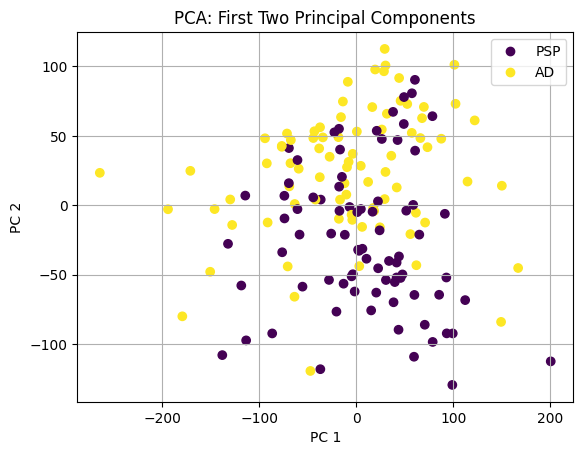

In [81]:
# Scatter plot of the first two principal components. 

import matplotlib.pyplot as plt 
colors = [0,1]
#plt.scatter(pca.components_[0],pca.components_[1],cmap='viridis')
plot=plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y)
#plt.scatter(range(len(pca.components_[0])),pca.components_[0],c='r', label='PC 1')
#plt.scatter(pca.components_[1],range(len(pca.components_[1])), c='b', label='PC 2') 
plt.title('PCA: First Two Principal Components') 
plt.xlabel('PC 1') 
plt.ylabel('PC 2')
plt.grid() 
plt.legend(handles=plot.legend_elements()[0], labels=list(df['Diagnosis'].unique())) 
plt.show()

#### Q1: Is the dataset linearly separable?


No, In my opinion, we cannot seperate the dataset linearly with the first and second principle components

### Section 4: SVM classifier  - [20 points]
 

- Complete the 'evaluate_classifier' function to implement a SVM classifier. Use GridSearchCV to search for the optimal kernel and parameter C (C determines the margin width).
- Use 10-fold StratifiedKFold for cross-validation (CV) when searching. Set scoring to 'accuracy'. StratifiedKFold will divide our dataset into 10 sets, the model will be trained on 9 sets and tested on 1 set. This results in 10 models, each fitted on different combinations of sets. 
- Print the best parameters and score found for each of X_rand, X_var, and X_projected after cross validation.

NOTE: We will not be doing a train-val-test split of the dataset in this assignment because of the small sample size. We will do a cross-validated train-test split for evaluations.


--------------------------


In [82]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, GridSearchCV


def evaluate_classifier(clf, X, y, scoring, parameters, n_splits=10):
    # Create StratifiedKFold validation
    stratK = StratifiedKFold(n_splits=n_splits)
    # Grid search for the two parameters (kernel, regularization parameter (inverse of margin))
    grid_search = GridSearchCV(clf, parameters, scoring=scoring, cv=stratK, n_jobs=-1)
    grid_search.fit(X, y)
    # Print the best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")
    return grid_search


parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.01, 0.1, 1, 10]}
scoring = 'accuracy'

# Intiate a SVM classifier
clf = svm.SVC()

print("Evaluating on random features \n")
evaluate_classifier(clf, X_rand, y, scoring, parameters)
print("\nEvaluating on top 1% features")
evaluate_classifier(clf, X_var, y, scoring, parameters)
print("\nEvaluating on PCA features \n")
evaluate_classifier(clf, X_projected, y, scoring, parameters)


Evaluating on random features 

Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best score: 0.7658088235294118

Evaluating on top 1% features
Best parameters: {'C': 10, 'kernel': 'poly'}
Best score: 0.7900735294117647

Evaluating on PCA features 

Best parameters: {'C': 10, 'kernel': 'rbf'}
Best score: 0.8099264705882353


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

#### Q2: Is `X_projected` performing better than the other two?


Yes, X_projected is performing slightly better than the top 1% features but is considerably better than the random feature selection. This might be attributed to the reason that PCA considers the direction of the highest variance and then projects the data on that axis, which is on a high level similar to taking features that contribute maximally to the variance in the data. 

### Section 5: Logistic regression - [30 points]

We explored three basic methods for feature selection. Another approach for having fewer features is regularization. In lasso regularization, as we increase the parameter (it is called 'alpha' in sklearn), more and more coefficients of our features are shrunk to zero.

- Build logistic regression models using lasso regularization (L1 penalty) with varying alpha values.  
- We'll perform cross-validation using the 'cross_validate' function to measure the performance of models. We will again use StratifiedKFold with 10 splits, but remember to get the splits on the original dataframe 'X'. 
    - Set scoring to 'accuracy'.
    - Record the mean test accuracy across CV splits for each alpha.
    - Record the mean number of non-zero coefficients across CV splits for each alpha.
- Repeat the above process but use ridge regression (l2 penalty) in logistic regression.
- Plot the number of non-zero feature coefficients recorded in both lasso and ridge regression versus alpha.  
- Plot cv accuracy recorded for both penalties versus alpha. Write two lines explaining why accuracy decreases as we increase alpha in lasso regression?


Note: It may take awhile to run. Also, you can ignore any possible messages regarding convergence.

--------------------------


#### Accuracy in Lasso is not decreasing (Check)

In [83]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression


alphas = np.array([0.1, 1, 10, 100, 1000])
lasso_cv_acc = []
lasso_non_zero_coeff = []
ridge_non_zero_coeff = []
ridge_cv_acc = []

# Create StratifiedKFold validation of 10 splits on 'X'
stratK = StratifiedKFold(n_splits=10)
for a in alphas:
    # Instantiate a logistic regression object. Use 'saga' solver and 'l1' penalty. 
    LR=LogisticRegression(penalty='l1', C=1/a, solver='saga')
    # Read on how parameter'C' and 'alpha' are related in logistic regression
    LR.fit(X, y)
    
    # C in logistic regression is the inverse of alpha in the two regularization methods.

    # Perform cross validation as described above.
    lasso = cross_validate(LR, X, y, cv=stratK, scoring='accuracy', return_estimator=True)
    # Record mean of test_score of all 10 models.
    lasso_cv_acc.append(np.mean(lasso['test_score']))
    # Record mean of number of non zero coeefeicitens of all 10 models
    lassocoeff=[np.count_nonzero(est.coef_) for est in lasso['estimator']]
    lasso_non_zero_coeff.append(np.mean(lassocoeff))
for a in alphas:

    # Repeat the above but with 'l2' penalty 
    LR2=LogisticRegression(penalty='l2', C=1/a, solver='saga')
    LR2.fit(X, y)
    ridge = cross_validate(LR2, X, y, cv=stratK, scoring='accuracy', return_estimator=True)
    ridge_cv_acc.append(np.mean(ridge['test_score']))
    ridgecoeffs=[np.count_nonzero(est.coef_) for est in ridge['estimator']]
    ridge_non_zero_coeff.append(np.mean(ridgecoeffs))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

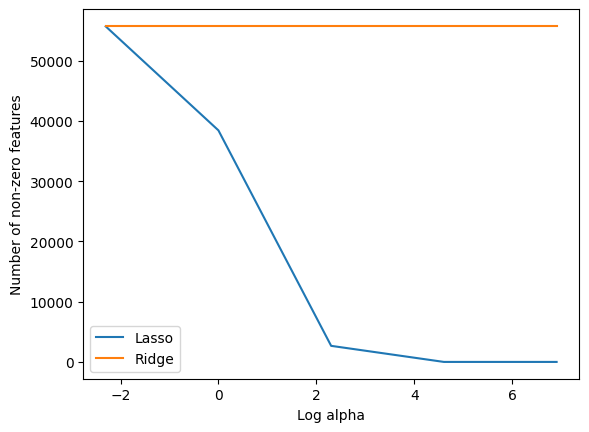

In [84]:
# Plot log of alpha vs number of non zero features. 

import matplotlib.pyplot as plt


plt.xlabel('Log alpha')
plt.ylabel('Number of non-zero features')
plt.plot(np.log(alphas), lasso_non_zero_coeff, label='Lasso')
plt.plot(np.log(alphas), ridge_non_zero_coeff, label='Ridge')
plt.legend(loc="lower left")
plt.show()


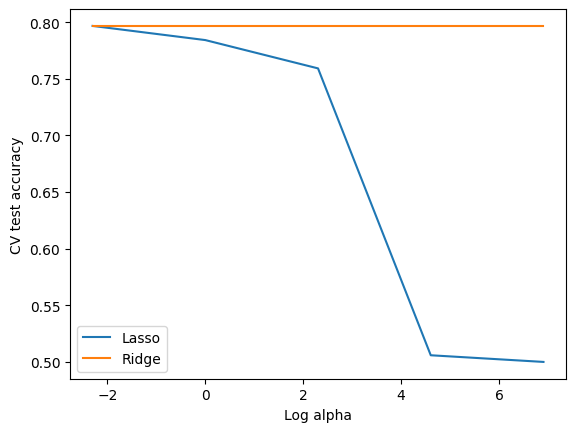

In [85]:
# Plot log of alpha vs mean CV test accuracy. 

plt.xlabel('Log alpha')
plt.ylabel('CV test accuracy')
plt.plot(np.log(alphas), lasso_cv_acc, label='Lasso')
plt.plot(np.log(alphas), ridge_cv_acc, label='Ridge')
plt.legend(loc="lower left")
plt.show()


#### Q3: Write a brief explanation for why the accuracy is decreasing in Lasso.


This is just the way Lasso assigns weights to the features vs how it assigns weights to Ridge regression, Lasso, with increasing alpha drops features out of the model or makes the weights as zero vs Ridge makes the features closer to zero but never zero so, for ridge regression (regularization) the features still contribute towards explaining the variability in the model vs Lasso which just drops them out of the model

### Section 6: Random forest  - [25 points]
 
In this section, we will implement a random forest algorithm on X_projected (i.e., the data reduced using PCA). We will vary the number of trees and features considered when splitting nodes. 

-  Build random forest models with varying tree counts and features to consider when looking for the split.
-  Perform similar cross-validate with stratified folds, as in Section 5..
-  Record accuracies obtained for the test set for each hyperparameter combination.
-  Plot test accuracy vs tree count for each #features (m, m//2, sqrt(m)) we are using.
-  Repeat the above using just the first 25 components of X_projected (you may create a new cell(s) for this).

Note: Don't forget the last step. 

--------------------------


In [86]:
from sklearn.ensemble import RandomForestClassifier

X_rf = X_projected

num_trees = [1, 50, 100, 200, 300, 500, 1000]
m =  X_rf.shape[1]
max_features = [ m, m//2, 'sqrt']
test_accs = []

# Create StratifiedKFold validation
stratK = StratifiedKFold(n_splits=10)
for tree in num_trees:
    for features in max_features:
        # Instantiate a random forest object. Set max_depth=5. 
        RF = RandomForestClassifier(n_estimators=tree, max_depth=5, max_features=features)
        # Perform cross validation
        rf = cross_validate(RF, X_rf, y, cv=stratK, scoring='accuracy')
        # Record the mean of CV test scores 
    test_accs.append(np.mean(rf['test_score']))

Random forest, with first 25 components of X_projected

In [114]:

X_rf_25 = X_projected[0:25]
y_25 = y[0:25]
num_trees_25 = [1, 50, 100, 200, 300, 500, 1000]
m_25 =  X_rf_25.shape[1]
max_features_25 = [ m, m//2, 'sqrt']
test_accs_25 = []

# Create StratifiedKFold validation
stratK = StratifiedKFold(n_splits=10)
for tree in num_trees:
    for features in max_features:
        # Instantiate a random forest object. Set max_depth=5. 
        RF = RandomForestClassifier(n_estimators=tree, max_depth=5, max_features=features)
        # Perform cross validation
        rf_25 = cross_validate(RF, X_rf_25, y_25, cv=stratK, scoring='accuracy')
        # Record the mean of CV test scores 
    test_accs_25.append(np.mean(rf_25['test_score']))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-p

In [115]:
#test_accs_25

[np.float64(0.7166666666666666),
 np.float64(0.7333333333333333),
 np.float64(0.7833333333333333),
 np.float64(0.7833333333333333),
 np.float64(0.7833333333333333),
 np.float64(0.7833333333333333),
 np.float64(0.7833333333333333)]

### Plot Cross Validation accuracy with number of trees

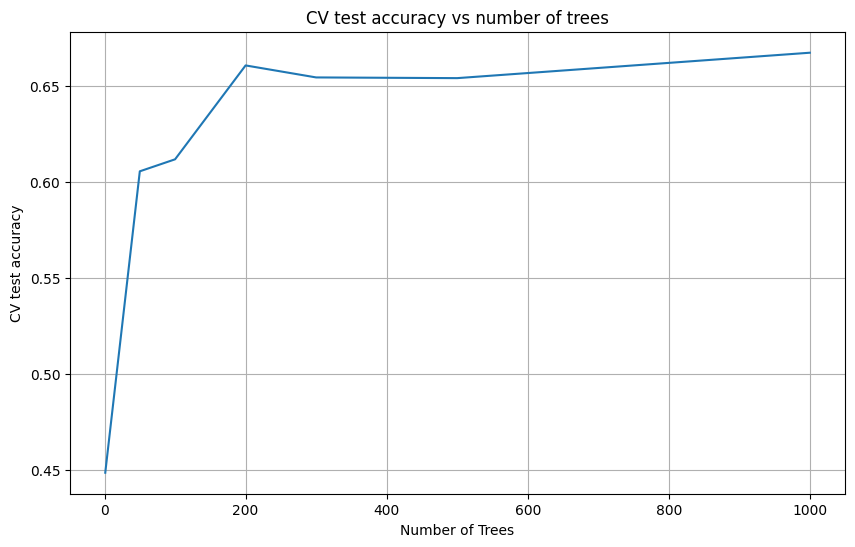

In [118]:
# Plot CV test accuracy vs number of trees 
plt.figure(figsize=(10, 6))
plt.xlabel('Number of Trees')
plt.ylabel('CV test accuracy')
plt.title('CV test accuracy vs number of trees')
k=0
#for i, max_feat in enumerate(max_features):
    #for j, tree in enumerate(num_trees):
        #print(f"i:{i} j:{j}")
        
        #print(i*len(num_trees)+j)
        #print(k)
        #plt.plot(tree, test_accs[j], '-')
        #k+=1
        #plt.plot(tree, test_accs[i], label="max_features = "+str(max_feat))
        #plt.plot(tree, test_accs[j], 'o', label="max_features = "+str(max_features[0]))
plt.plot(num_trees, test_accs[0:7], '-', label="Accuracy with increasing number of trees")
#plt.plot(max_features, test_accs[], '-', label="Accuracy with increasing number of features")
#plt.legend()
plt.grid()
plt.show()



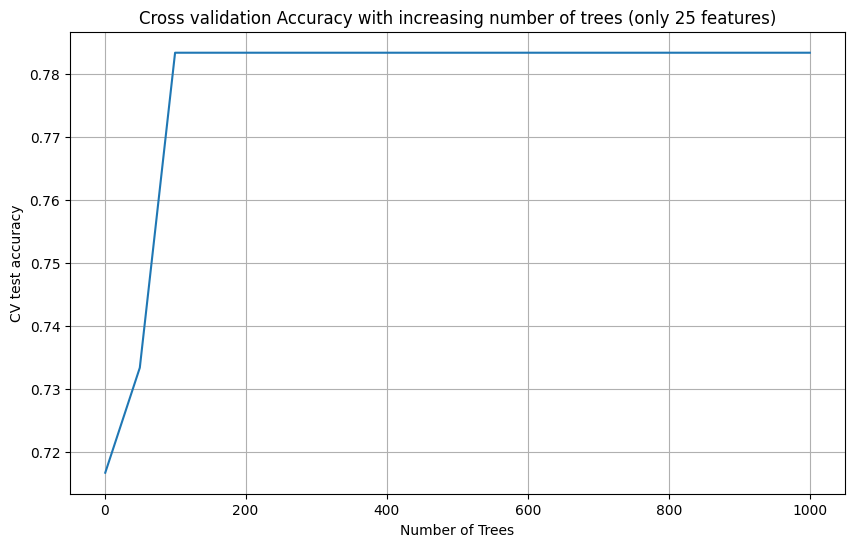

In [117]:
plt.figure(figsize=(10, 6))
plt.xlabel('Number of Trees')
plt.ylabel('CV test accuracy')
plt.title('Cross validation Accuracy with increasing number of trees (only 25 features)')
k=0
#for i, max_feat in enumerate(max_features):
    #for j, tree in enumerate(num_trees):
        #print(f"i:{i} j:{j}")
        
        #print(i*len(num_trees)+j)
        #print(k)
        #plt.plot(tree, test_accs[j], '-')
        #k+=1
        #plt.plot(tree, test_accs[i], label="max_features = "+str(max_feat))
        #plt.plot(tree, test_accs[j], 'o', label="max_features = "+str(max_features[0]))
plt.plot(num_trees, test_accs_25[0:7], '-', label="Accuracy with increasing number of trees")
#plt.plot(max_features, test_accs[], '-', label="Accuracy with increasing number of features")
#plt.legend()
plt.grid()
plt.show()

#### Q4: What are your observations from the plots above?


The cross validation accuracy with the first 25 components achieve a higher accuracy than the entire X_projected matrix. This might be because of overfitting, a smaller set of features might aid the model in overfitting the data as the number of trees are increased. But for the larger sample, even with larger number of trees it is not able to have a constant high accuracy because of the larger number of features. It is not able to overfit the data.

### 1 minute feedback 

Your feedback is valuable! Please take some time to fill out the assignment feedback form using the below link. Thank you.

This form is anonymous. 

https://forms.gle/S6kVsKaiL7ciKHWw9